In [197]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [198]:
current_directory = os.getcwd()
print(current_directory)
train = pd.read_csv('data/train.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')

D:\GitHub\keras_learning\training_project\tabular_playground_series_Apr_2022


In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence.

在本次競賽中，您將對 60 秒的感測器資料序列進行分類，找出受試者在序列持續時間內處於兩種活動狀態的其中一種。

## Files and Field Descriptions
- train.csv - the training set, comprising ~26,000 60-second recordings of thirteen biological sensors for almost one thousand experimental participants
    - sequence - a unique id for each sequence
    - subject - a unique id for the subject in the experiment
    - step - time step of the recording, in one second intervals
    - sensor_00 - sensor_12 - the value for each of the thirteen sensors at that time step
- train_labels.csv - the class label for each sequence.
    - sequence - the unique id for each sequence.
    - state - the state associated to each sequence. This is the target which you are trying to predict.
- test.csv - the test set. For each of the ~12,000 sequences, you should predict a value for that sequence's state.
- sample_submission.csv - a sample submission file in the correct format.

In [199]:
train

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


由上表與題目提示可得知，每一秒會記錄一列，每 60 列代表一個 `sequence`

In [200]:
train_labels

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25963,25963,1
25964,25964,0
25965,25965,1
25966,25966,1


確認資料是否有缺漏，本題的資料都很完美，沒有有缺漏的地方

In [201]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


## 正規化資料

萃取需要的資料

In [202]:
x_train = train.loc[:, ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']]
x_test = test.loc[:, ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']]
y_labels = train_labels.loc[:, ['state']]
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_labels = y_labels.to_numpy()

In [203]:
print(x_train.shape)
print(y_labels.shape)

(1558080, 13)
(25968, 1)


In [204]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

## 加回時間標籤

In [205]:
sequence = 60
# timestamp = []
# times = int(x_train.shape[0] / sequence)
# for i in range(times):
#     for j in range(1, 61):
#         timestamp.append(j)
        
# timestamp = np.array(timestamp)
# print(timestamp.shape)# 

合併 timestamp 到原資料集

In [206]:
# x_train = np.column_stack((x_train, timestamp))


In [207]:
# print(x_train.shape[1])

## 整理資料

準備進入訓練的資料格式：設定 sequence
sequence 設為 60 ，代表過去 60 秒的資訊。

In [208]:
X_train = np.reshape(x_train, (-1, sequence, x_train.shape[1]))
X_test = np.reshape(x_test, (-1, sequence, x_test.shape[1]))
X_train.shape

(25968, 60, 13)

In [209]:
X_val = X_train[23372:]
partial_x_train = X_train[:23372]
Y_val = y_labels[23372:]
partial_y_train = y_labels[:23372]

print(partial_x_train.shape)
print(X_val.shape)

(23372, 60, 13)
(2596, 60, 13)


In [210]:
(partial_x_train.shape[1:],)

((60, 13),)

## 搭建 LSTM 網路

In [211]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras import losses
from keras import metrics

In [212]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape = partial_x_train.shape[1:]))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 56, 32)            2112      
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 18, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 14, 64)            10304     
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 lstm_56 (LSTM)              (None, 4, 32)             12416     
                                                                 
 lstm_57 (LSTM)              (None, 4, 32)           

In [213]:
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=25,
          batch_size=60,
          validation_data=(X_val, Y_val),
          )

Epoch 1/25
390/390 [==============================] - 39s 84ms/step - loss: 0.6250 - binary_accuracy: 0.6470 - val_loss: 0.6782 - val_binary_accuracy: 0.5921
Epoch 2/25
390/390 [==============================] - 30s 78ms/step - loss: 0.5206 - binary_accuracy: 0.7438 - val_loss: 0.6164 - val_binary_accuracy: 0.7084
Epoch 3/25
390/390 [==============================] - 32s 81ms/step - loss: 0.4645 - binary_accuracy: 0.7777 - val_loss: 0.4514 - val_binary_accuracy: 0.7866
Epoch 4/25
390/390 [==============================] - 32s 81ms/step - loss: 0.4365 - binary_accuracy: 0.7924 - val_loss: 0.4499 - val_binary_accuracy: 0.7920
Epoch 5/25
390/390 [==============================] - 30s 77ms/step - loss: 0.4170 - binary_accuracy: 0.8058 - val_loss: 0.4083 - val_binary_accuracy: 0.8059
Epoch 6/25
390/390 [==============================] - 32s 82ms/step - loss: 0.3990 - binary_accuracy: 0.8141 - val_loss: 0.3986 - val_binary_accuracy: 0.8155
Epoch 7/25
390/390 [==============================] 

## 視覺化結果

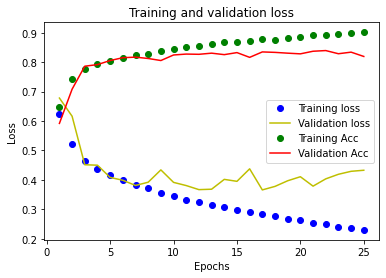

In [214]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.plot(epochs, acc, 'go', label='Training Acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 預測真實資料

In [215]:
y_pred = model.predict(X_test)

y_pred = (y_pred[:] > 0.5).astype(int)

y_pred = np.reshape(y_pred, (-1,))

y_pred_df = pd.DataFrame(y_pred, columns=['state'])

y_pred_df.insert(0, "sequence", np.arange(25968, 25968+y_pred_df.shape[0]))


In [216]:
y_pred_df

,sequence,state
0,25968,1
1,25969,1
2,25970,0
3,25971,0
4,25972,1
...,...,...
12213,38181,1
12214,38182,1
12215,38183,0
12216,38184,1


In [217]:
y_pred_df.to_csv('submission.csv', index=False)